In [1]:
import copy
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader

In [2]:
x_data = np.linspace(-100, 100, 30000)
y_data = np.sin(x_data) / x_data

In [3]:
dataset = Dataset(torch.tensor(x_data).float(), torch.tensor(y_data).float())
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

activation = nn.Sigmoid()

In [4]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x
    
model = ELM(1, 1000, 1)

In [5]:
H = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].reshape(1, -1)).T
Y = trainset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ Y.reshape(1, -1, 1)
model.fc2.weight.data = W2[0].T

In [6]:
def infGain(model, loader, i):
    model.eval()
    loss = 0
    for x, y in loader:
        x, y = x.reshape(-1, 1), y.reshape(-1, 1)
        preds = model(x)
        loss += torch.norm(preds - y) 
    return loss

def prune(model, loader):
    inf = []
    model.eval()
    with torch.no_grad():
        for i in range(model.fc1.out_features):
            fc1_weight_temp = copy.deepcopy(model.fc1.weight.data[i])
            fc1_bias_temp = copy.deepcopy(model.fc1.bias.data[i])
            fc2_weight_temp = copy.deepcopy(model.fc2.weight.data[:,i])
            model.fc1.weight.data[i] = 0
            model.fc1.bias.data[i] = 0
            model.fc2.weight.data[:,i] = 0
            inf.append(infGain(model, loader, i))
            model.fc1.weight.data[i] = fc1_weight_temp
            model.fc1.bias.data[i] = fc1_bias_temp
            model.fc2.weight.data[:,i] = fc2_weight_temp
        neuron_to_prune = np.argmin(inf)
        pruned_model = ELM(1, model.fc1.out_features-1, 1)
        pruned_model.fc1.weight.data = torch.cat([model.fc1.weight.data[:neuron_to_prune], model.fc1.weight.data[neuron_to_prune+1:]])
        pruned_model.fc1.bias.data = torch.cat([model.fc1.bias.data[:neuron_to_prune], model.fc1.bias.data[neuron_to_prune+1:]])
        pruned_model.fc2.weight.data = torch.cat([model.fc2.weight.data[:,:neuron_to_prune],model.fc2.weight.data[:,neuron_to_prune+1:]], dim=1)
    return pruned_model

for _ in range(2):
    model = prune(model, testloader)

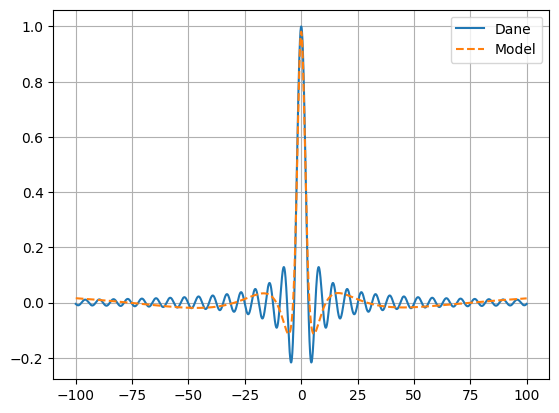

In [7]:
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1).float()).detach().numpy(), '--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()